# Kernel Density Estimation event-based model (KDE-EBM) of prematurity

----
<div class="alert alert-block alert-info">
Update 2021: New KDE models using a new dataset including much more subjects and, this time, volumetric brain data
</div>

KDE EBM built on historical Geneva data in the following conditions:
- CTRLS: full-terms
- PM: preterms

Authors: Serafeim Loukas (EPFL / U. Geneva), Neil Oxtoby (UCL) et al.

For this to work, you must:
- Install https://github.com/ucl-pond/kde_ebm (and its dependencies) and checkout branch `variable_bandwidth_cdf`
- Have `wp9_ebm_utilities.py` in the current directory (see `import` statement below)
- Have the data saved in an appropriate location

<div class="alert alert-block alert-danger">
Abnormality direction: "default" i.e. normal -> abnormal 
</div>

# Imports

In [1]:
%reset -f

In [2]:
#* To modify on the spot the wp9_ebm_utilities.py file and charges to be pulled 
#  automatically (no need to re-run the notebook)
%load_ext autoreload
%autoreload 2

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
import os,sys,time,glob
from datetime import datetime
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.patches as mpatches
import pystan
#* Plotting
from matplotlib import pyplot as plt
import seaborn as sn
colors = sn.color_palette('viridis', 9)
plt.style.use('ggplot')
from matplotlib import rcParams # For changing default figure size
plt.rcParams.update({'font.size': 14})

# Non-standard Imports

In [5]:
#* KDE EBM
from kde_ebm.mixture_model import fit_all_kde_models, get_prob_mat
from kde_ebm.plotting import mixture_model_grid, mcmc_uncert_mat, mcmc_trace, stage_histogram
from kde_ebm.mcmc import mcmc, parallel_bootstrap, bootstrap_ebm, bootstrap_ebm_fixedMM, bootstrap_ebm_return_mixtures
#* EBM Utilities
import wp9_ebm_utilities as ebm_ute
#* Saving
import pickle

# Data and Convenience variables

In [6]:
#* Analysis choices
run_manual_check_of_mixture_models = True
fixed_controls = True # flag for the KDE-EBM

#* Data
raw_csv = '...'

#* Convenience variables
nom = 'preterm_ebm'
rundate = str(datetime.now().date()).replace('-','')
fname_save = "{0}-results-{1}-pickle".format(nom,rundate)

#* Included "events"/"biomarkers"
event_sets = ['volumes_clean']
event_selector = event_sets[0]

print("Data: ",event_selector)
if event_selector=='volumes_clean':
    raw_csv = '/data/cognitive_dataset_2020_TEA_norm_ICC_all_V2.csv'
else:
    raise ValueError("Invalid case")
                                    
print(raw_csv)

Data:  volumes_clean
/data/cognitive_dataset_2020_TEA_norm_ICC_all_V2.csv


# Select "patient" group

In [7]:
#* Select EP / IUGR 
# (No selection for "volumes" case)
nom_plus = 'PT'

#* Map diagnoses for KDE-EBM code: 0=control, 1=patient
if nom_plus=='PT':
    dx_map = {0:1,1:0} # map preterms (0) to patients (1) and terms (1) to controls (0)
elif nom_plus=='':
    dx_map = {}
nom += '_'+nom_plus
print("Abnormal target group: ", nom_plus)

Abnormal target group:  PT


# Analysis

In [8]:
raw_csv = os.getcwd() + raw_csv
raw_csv

'/Users/loukas/Desktop/preterm_ebms_open/data/cognitive_dataset_2020_TEA_norm_ICC_all_V2.csv'

## Data Preparation

In [9]:
#*** Prep: data loading and `preliminaries()` function
fname = '{0}-prepped.csv'.format(nom)
df, ebm_scores, ebm_scores_labels = ebm_ute.preliminaries(
    wd=os.getcwd(),
    fname_save=fname,
    csv_file=raw_csv,
    events_set=event_selector
)
bl = pd.Series(data=np.ones(df.shape[0])).astype(bool)
dx_column = 'DX'

df['DX'] = df['DX'].map(dx_map)
df.tail(5)

   ...Executing preliminaries() function.


,Unnamed: 0,Cortical gray matter total,Unmyelinated white matter total,Subcortical gray matter total,CSF,Cerebellum,Brainstem,id,N,MDI 18-24 months,...,Group PSEQ (= 2 if < 85),PSIM 5 years,Group PSIM (= 2 if < 85),PMC 5 years,Group PMC 18-24 month (= 2 if < 85),CONN 5 years,Age gest,Birthweight (g),SES / Largo,DX
251,251,0.390482,0.306515,0.044679,0.192464,0.054869,0.010991,0,300,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29.14,NaN,NaN,1
252,252,0.354168,0.347177,0.058416,0.168518,0.059152,0.012568,0,301,108.0,...,1.0,78,2.0,95,1.0,,29.00,1400.0,9.0,1
253,253,0.359108,0.336656,0.051819,0.195819,0.045577,0.011020,0,303,78.0,...,1.0,94,1.0,106,1.0,93,28.57,1150.0,10.0,1
254,254,0.361735,0.344812,0.052195,0.182619,0.047081,0.011559,0,304,78.0,...,1.0,100,1.0,101,1.0,83,28.57,1030.0,10.0,1
255,255,0.390040,0.302132,0.047767,0.190048,0.057629,0.012385,0,305,108.0,...,1.0,106,1.0,106,1.0,91,30.00,1600.0,2.0,1


In [10]:
df.shape

(256, 24)

In [11]:
print("###################################################")
print("Number of controls: {}".format((df.DX==0).sum()))
print("###################################################")
print("Number of patients: {}".format((df.DX==1).sum()))
print("###################################################")

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


###################################################
Number of controls: 75
###################################################
Number of patients: 181
###################################################


In [12]:
detrend_bool = False

#*** Prep: Detrending
# - e.g., Sex, Age, Education, Total Intracranial Volume (MRI volumes only)
# - First log-transform where appropriate
fname = fname.replace('.csv','-detrended.csv')
if detrend_bool:
    print('detrend_data():       Detrending data (c.f. default_events() for marker selection options)')
else:
    print('detrend_data():       Not detrending data')
df['normals_EBM'] = df[dx_column]==0
detrend_covars = [] #'HAD_anx','HAD_dep'
df_detrended, markers_all_detrended = ebm_ute.detrend_data(
    df,
    bl,
    fname_save=fname,
    covariates_labels=detrend_covars,
    detrend_bool=detrend_bool,
    events_set=event_selector
)
df_detrended.head(5)

detrend_data():       Not detrending data
   ...Executing detrend_data() function.


,Unnamed: 0,Cortical gray matter total,Unmyelinated white matter total,Subcortical gray matter total,CSF,Cerebellum,Brainstem,id,N,MDI 18-24 months,...,Birthweight (g),SES / Largo,DX,normals_EBM,Cortical gray matter total-detrended,Unmyelinated white matter total-detrended,Subcortical gray matter total-detrended,CSF-detrended,Cerebellum-detrended,Brainstem-detrended
0,0,0.324017,0.334599,0.050094,0.227470,0.051706,0.012114,0,1,93.0,...,900.0,4.0,1,False,0.324017,0.334599,0.050094,0.227470,0.051706,0.012114
1,1,0.362349,0.354552,0.048820,0.171497,0.050210,0.012572,0,5,90.0,...,1480.0,7.0,1,False,0.362349,0.354552,0.048820,0.171497,0.050210,0.012572
2,2,0.345039,0.354693,0.045011,0.195444,0.049161,0.010653,0,6,116.0,...,1080.0,NaN,1,False,0.345039,0.354693,0.045011,0.195444,0.049161,0.010653
3,3,0.389530,0.365612,0.045329,0.134021,0.053222,0.012285,0,7,92.0,...,1590.0,2.0,1,False,0.389530,0.365612,0.045329,0.134021,0.053222,0.012285
4,4,0.356756,0.354976,0.054019,0.162449,0.058725,0.013075,0,10,88.0,...,770.0,5.0,1,False,0.356756,0.354976,0.054019,0.162449,0.058725,0.013075


*** Automatic detection of abnormality direction in candidate features ***
    Features that decline:
     Unmyelinated white matter total-detrended, Subcortical gray matter total-detrended, Cerebellum-detrended, Brainstem-detrended
    Features that increase:
     Cortical gray matter total-detrended, CSF-detrended


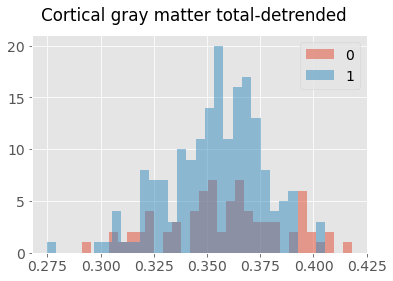

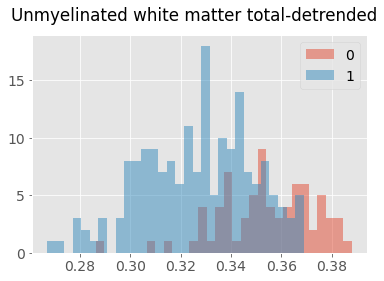

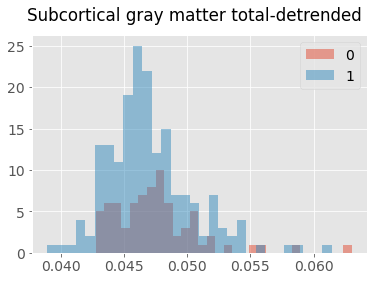

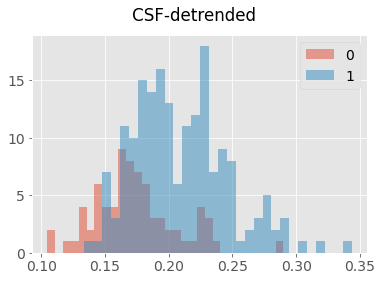

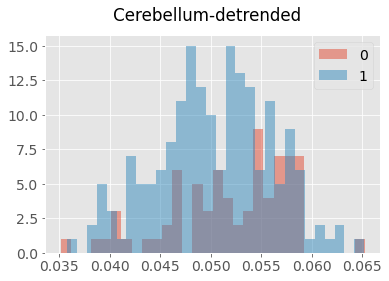

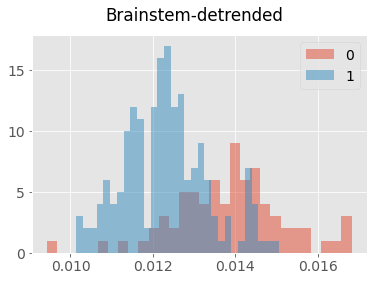

In [13]:
#* Abnormality direction
print('*** Automatic detection of abnormality direction in candidate features ***')

candidate_features = markers_all_detrended

#df_detrended['Group'] = df_detrended['id'].map({1:'Mild PT',2:'EP',3:'IUGR',4:'Term (controls)'})

df_detrended['Group'] = df_detrended['id'].map({0:'Preterms',1:'Term (controls)'})
#* Histograms reveal that network metrics tend to be higher in controls
for metric in candidate_features: #e[0]:
    fig,ax=plt.subplots()
    #df_detrended.hist(column=metric,ax=ax,by='Group',sharex=True)
    for dx in range(0,2):
        r = df_detrended['DX'].values==dx
        ax.hist(x=df_detrended.loc[r][metric].values,label=str(dx), bins=30, alpha=0.5)
    ax.legend()
    fig.suptitle(metric)
    fig.show()
from kde_ebm.mixture_model.kde import disease_direction
y = df_detrended['DX'].values
candidate_features_abnormality_dirn = [] # after detrending
for feat,lab in zip(candidate_features,candidate_features):
    #* Check direction using CDFs
    x = np.array(df_detrended[feat].values)
    candidate_features_abnormality_dirn.append(disease_direction(x,y,label=lab))

features_that_decline = [f for f,a in zip(candidate_features,candidate_features_abnormality_dirn) if a<0]
features_that_increase = [f for f,a in zip(candidate_features,candidate_features_abnormality_dirn) if a>0]

print('    Features that decline:\n     {0}'.format(', '.join(features_that_decline))) 
print('    Features that increase:\n     {0}'.format(', '.join(features_that_increase))) 

if event_selector=='volumes_clean':
    # CSF tends to be higher in PM based on the literature
    # forcing that 
    candidate_features_abnormality_dirn = [-1, -1, -1, +1, -1,-1]
    
else:
    print('...Forcing abnormality direction to be decline, \n...since visual check of histograms show that network features tend to have higher values in controls')
    candidate_features_abnormality_dirn = [-1 for k in range(len(candidate_features_abnormality_dirn))]

candidate_features_abnormality_dirn_dict = dict(zip(candidate_features,candidate_features_abnormality_dirn))

----

## Manual inspection of mixture models ("event distributions")

#### Side notes: KDE fitting for each biomarker, Scott's normal reference rule for bandwidth estimation (https://github.com/ncfirth/kde_ebm_open/blob/master/kdeebm/mixture_model/kde.py#L99). Also: https://github.com/ncfirth/kde_ebm_open/blob/master/kdeebm/mixture_model/utils.py#L53


#### P(event) line = 1- p(no event) = 1- mixture.probability(horizon) (https://github.com/ncfirth/kde_ebm_open/blob/master/kdeebm/mixture_model/kde.py#L90)

manual_check_kdemm(): Checking mixture models manually
Take note of ones to remove, then edit ebm_ute.ebm_1_extract_data() accordingly (may have to re-load and re-run after editing)

I hope you kept note of the biomarker events you want to keep


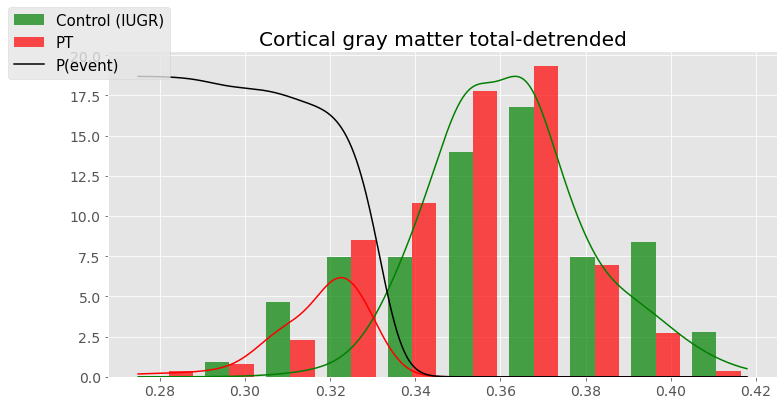

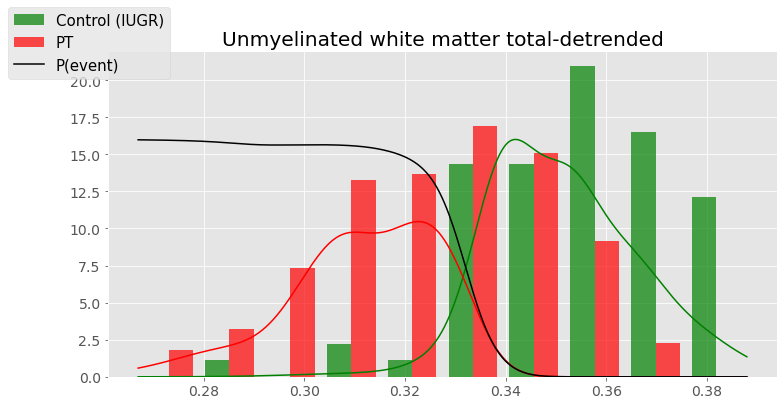

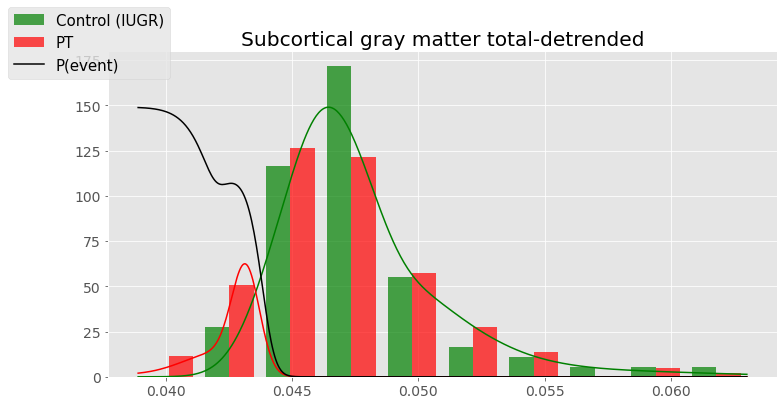

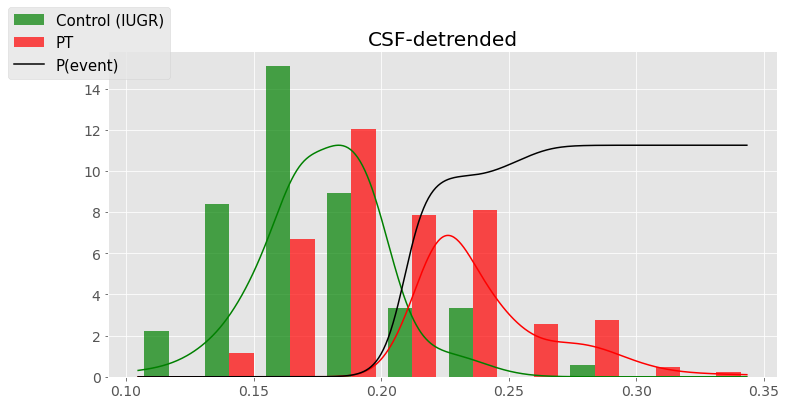

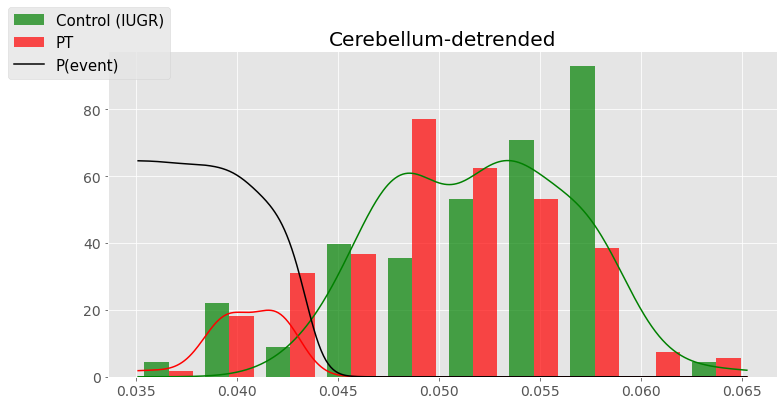

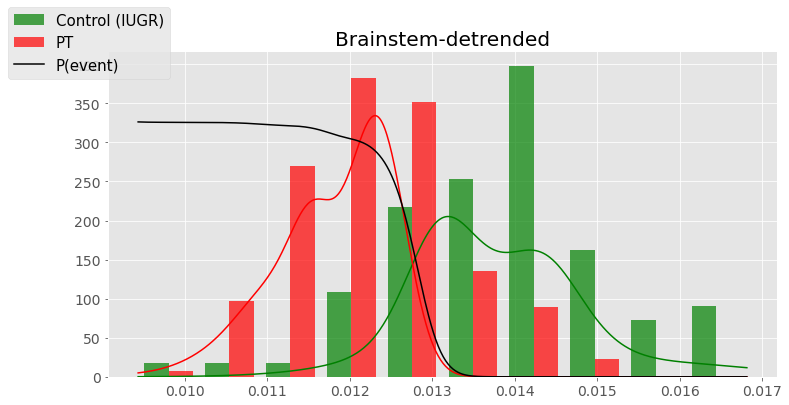

In [14]:
if run_manual_check_of_mixture_models:
    mck = 'manual_check_kdemm(): Checking mixture models manually'
    mck += '\nTake note of ones to remove, then edit ebm_ute.ebm_1_extract_data() accordingly (may have to re-load and re-run after editing)'
    print(mck)
    ebm_ute.manual_check_kdemm(
        df=df_detrended,
        markers=markers_all_detrended,
        hist_bool=True,
        implement_fixed_controls=fixed_controls,
        patholog_dirn_array=candidate_features_abnormality_dirn,
        sub=nom_plus
    )
    # for m in candidate_features:
    #     ebm_ute.manual_check_kdemm(
    #         df=df_detrended,
    #         markers=[m],
    #         hist_bool=True,
    #         implement_fixed_controls=fixed_controls,
    #         patholog_dirn_array=[candidate_features_abnormality_dirn_dict[m]],
    #         sub=nom_plus
    #     )
    #     fig = plt.gcf()
    #     fig.savefig('{0}-KDEMM-{1}-{2}.png'.format(nom,m,rundate))
else:
    print('Manual check of mixture models not performed')

----

## Missing data check

ebm_1_extract_data(): Extracting baseline data(make sure youve checked mixture models using manual_check_kdemm())
- also removing events having too much missing data per DX group)

 Manually postselected markers (e.g. removing KDE-MM failures): ['Cortical gray matter total-detrended', 'Unmyelinated white matter total-detrended', 'Subcortical gray matter total-detrended', 'CSF-detrended', 'Cerebellum-detrended', 'Brainstem-detrended']

   ...ebm_1_extract_data(): removed events having too much missing data: 
The following markers showed no significant statistical difference between controls and cases (Mann-Whitney U test; p > 0.05/N, N = number of postselected events):
  - Cortical gray matter total-detrended
  - Subcortical gray matter total-detrended
  - Cerebellum-detrended


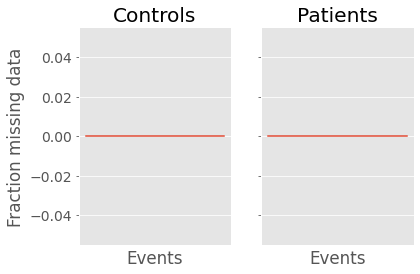

In [15]:
e1t = 'ebm_1_extract_data(): Extracting baseline data'
e1t += '(make sure you''ve checked mixture models using manual_check_kdemm())\n'
e1t += '- also removing events having too much missing data per DX group)'
print(e1t)
df_EBM, events, events_labels = ebm_ute.ebm_1_extract_data(df=df_detrended,
                                                           bl=bl,
                                                           markers=markers_all_detrended,
                                                           sub=nom_plus,
                                                           events_set=event_selector)

## Maximum-likelihood EBM (i.e. function `ebm_2_run`)

You should call your function ebm_2_run
ebm_2_run():          Building maximum likelihood model


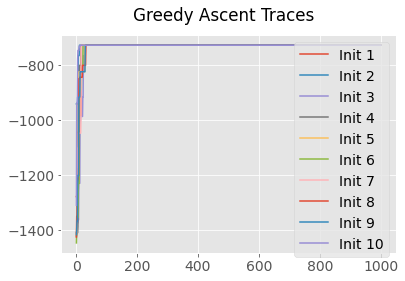

In [16]:
#*** EBM 2.1 Build the model
x = df_EBM[events].values
y = df_EBM[dx_column].values
candidate_features_abnormality_dirn = [candidate_features_abnormality_dirn_dict[m] for m in events]

#* Max likelihood sequence
check_flag = ebm_ute.check_for_save_file(file_name=fname_save,function=ebm_ute.ebm_2_run)
if check_flag == 1:
    print('ebm_2_run():          Loading existing results')
    pickle_file = open(fname_save,'rb')
    ebm_results = pickle.load(pickle_file)
    kde_mixtures = ebm_results["mixtures"]
    mcmc_samples = ebm_results["mcmc_samples"]
    seq_ml = ebm_results["sequence_ml"]
    pickle_file.close()
else:
    print('ebm_2_run():          Building maximum likelihood model')
    kde_mixtures, mcmc_samples, seq_ml = ebm_ute.ebm_2_run(x=x,y=y,events=events,patholog_dirn_array=candidate_features_abnormality_dirn,
                                                           plot_flag = False)
    #* Save
    ebm_results = { "mixtures": kde_mixtures, "mcmc_samples": mcmc_samples, "sequence_ml": seq_ml }
    #pickle_file = open(fname_save,'wb')
    #pickle_output = pickle.dump(ebm_results,pickle_file)
    #pickle_file.close()
    #sio.savemat(fname_save,ebm_results,appendmat=True)
    #shelve.savemat(fname_save,ebm_results,appendmat=True)

## Positional Variance Diagram

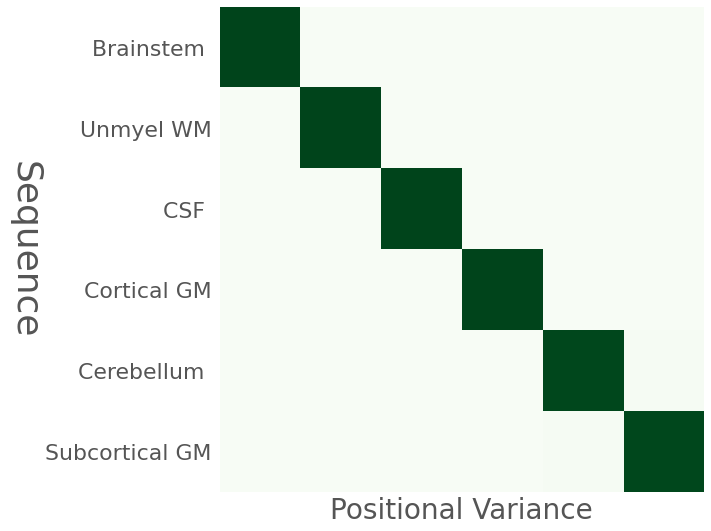

In [17]:
#*** Positional Variance Diagrams
pvd_ml, seq_ml = ebm_ute.extract_pvd(ml_order=seq_ml,samples=mcmc_samples)

#*** Positional Variance, reordered to match labels in events
reorder_ml = np.argsort(seq_ml)
pvd_ml_ = pvd_ml[:][reorder_ml]

############ It's no longer pretty from here, but it's easier to tweak the plots ############
ordr = 'ml_order'
seq_ = seq_ml
pvd_ = pvd_ml_
n_biomarkers = pvd_.shape[0]

fig, ax = plt.subplots(1,1,figsize=(10, 10),sharey=False)
labels = events_labels
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_]
ax.imshow(pvd_ml_[:][seq_], interpolation='nearest', cmap='Greens')
ax.set_title('',fontsize=28); txt1 = 'ML'

stp = 1
fs = 12
if n_biomarkers>8:
    stp = 3
    fs = 10
tick_marks_x = np.arange(0,n_biomarkers,stp)
tick_marks_x = []
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
#ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y-0)
ax.tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=22)
ax.set_ylabel('Sequence', fontsize=36,rotation=270,va='top')
ax.set_xlabel('Positional Variance', fontsize=28)
ax.grid(False)
fig.tight_layout()
f_name = '{0}-PVD_{1}-{2}-{3}.png'.format(nom,txt1,rundate,ordr)
#fig.savefig(f_name,dpi=300)

### Check mixture models in a convenient grid

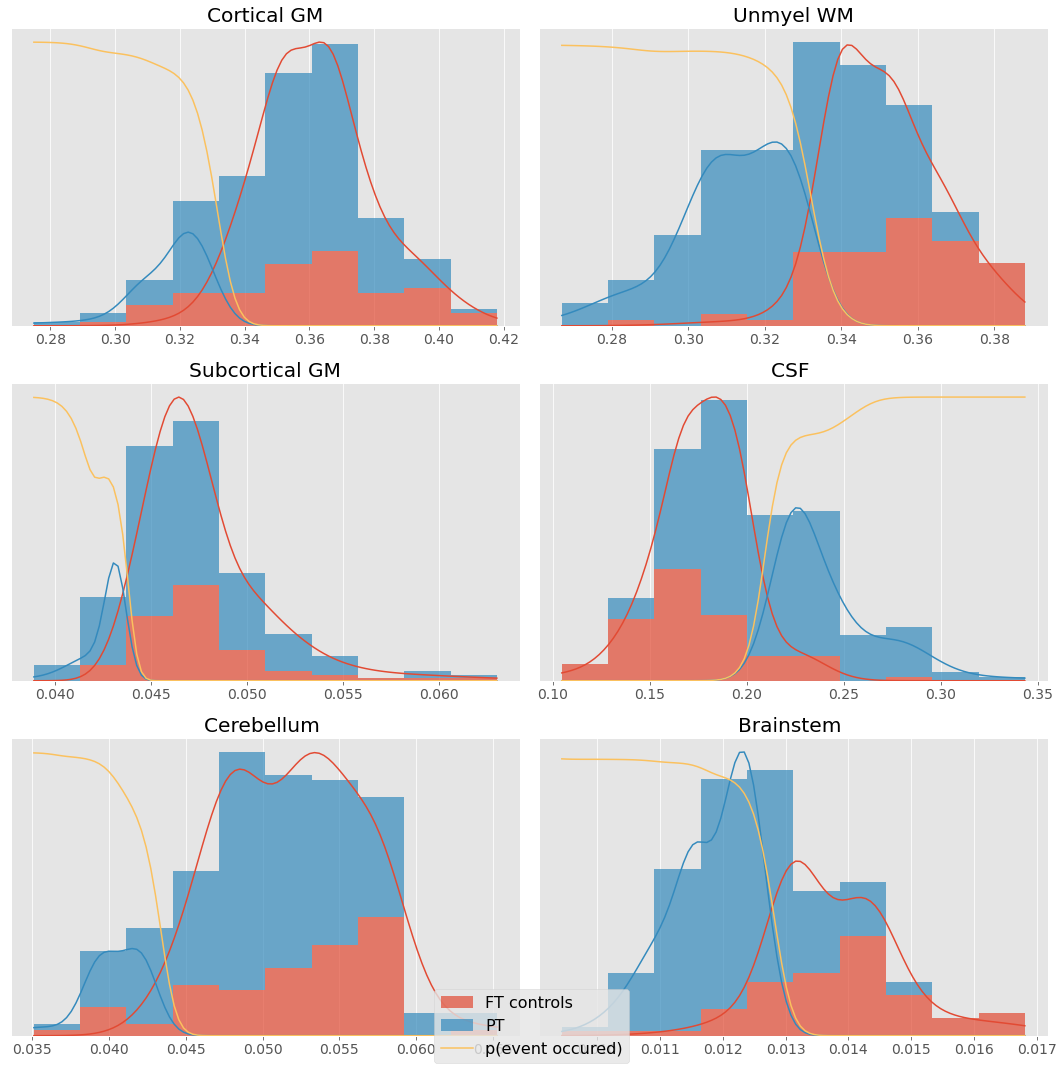

In [18]:
mixture_model_grid(x,y,kde_mixtures, score_names=events_labels,class_names = ['FT controls', nom_plus])
fig = plt.gcf()

##* I modify the figsize because the subplots were not visible
fig_size = fig.get_size_inches()
sizefactor = 1.5 #Set a zoom factor
plt.gcf().set_size_inches(sizefactor * fig_size)

fig.tight_layout()
f_name = '{0}-MM_Grid-{1}.png'.format(nom,rundate)
#fig.savefig(f_name,dpi=300)

## Cross-validation of EBM

ebm_2_cv():           Running 10-fold cross-validation
CV fold 1 of 10
CV fold 2 of 10
CV fold 3 of 10
CV fold 4 of 10
CV fold 5 of 10
CV fold 6 of 10
CV fold 7 of 10
CV fold 8 of 10
CV fold 9 of 10
CV fold 10 of 10


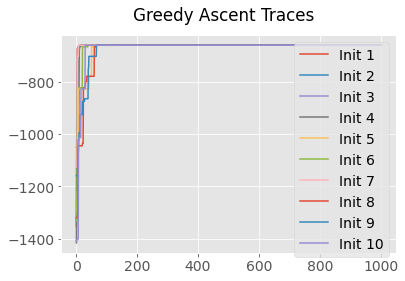

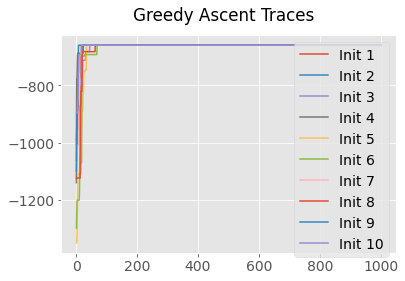

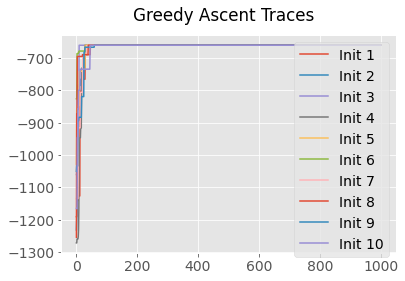

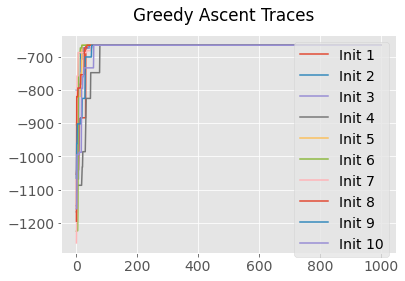

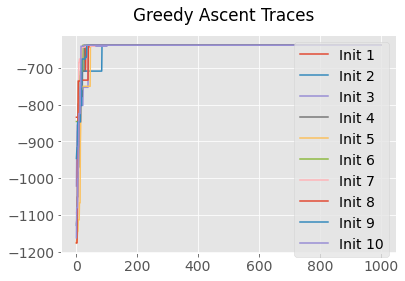

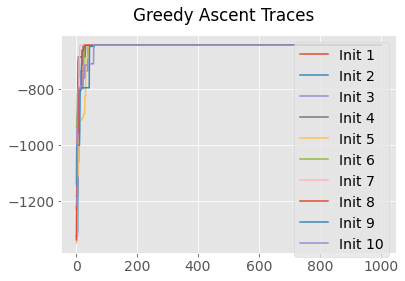

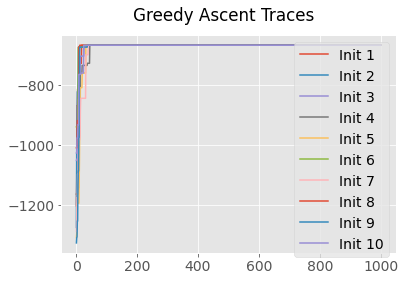

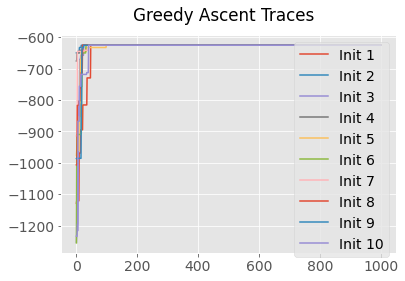

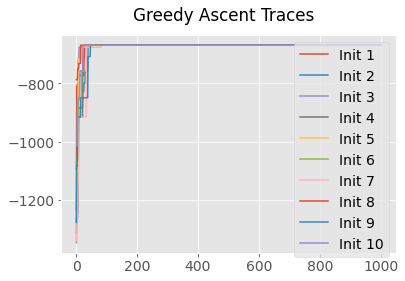

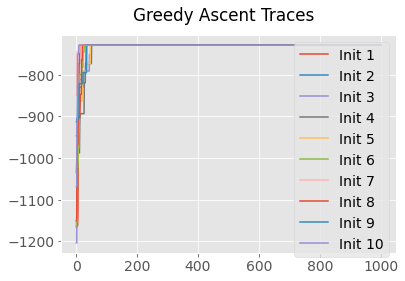

In [19]:
#*** EBM 2.2 Cross-validation: 10-fold
#  NOTE: Could use CV to do event postselection (remove events having multimodal positional variance)
if "mixtures_cv" in ebm_results:
    print('ebm_2_cv():           Not running CV: existing results detected.')
    kde_mixtures_cv = ebm_results["mixtures_cv"]
    mcmc_samples_cv = ebm_results["mcmc_samples_cv"]
    seqs_cv = ebm_results["sequences_cv"]
else:
    #* Check for smallest group (must be larger than k-folds)
    n_dx = []
    for dx_ in df[dx_column].unique():
        n_dx.append(sum(df[dx_column]==dx_))
    if min(n_dx)<10:
        k_folds = min(n_dx)
    else:
        k_folds = 10
    from sklearn.model_selection import StratifiedKFold
    cv_folds = StratifiedKFold(n_splits=k_folds, shuffle=False, random_state=None)
    print('ebm_2_cv():           Running {0}-fold cross-validation'.format(k_folds))
    kde_mixtures_cv, mcmc_samples_cv, seqs_cv = ebm_ute.ebm_2_cv(
        x=x,
        y=y,
        events=events,
        cv_folds=cv_folds,
        implement_fixed_controls=fixed_controls,
        patholog_dirn_array=candidate_features_abnormality_dirn
    )
    #kde_mixtures_cv, mcmc_samples_cv, seqs_cv = ebm_ute.ebm_2_cv(x=x,y=y,events=events,cv_folds=cv_folds)
    
    #* Save
    ebm_results["mixtures_cv"] = kde_mixtures_cv
    ebm_results["mcmc_samples_cv"] = mcmc_samples_cv
    ebm_results["sequences_cv"] = seqs_cv
    #pickle_file = open(fname_save,'wb')
    #pickle_output = pickle.dump(ebm_results,pickle_file)
    #pickle_file.close()

## Positional variance diagram: cross-validation and max-likelihood side-by-side

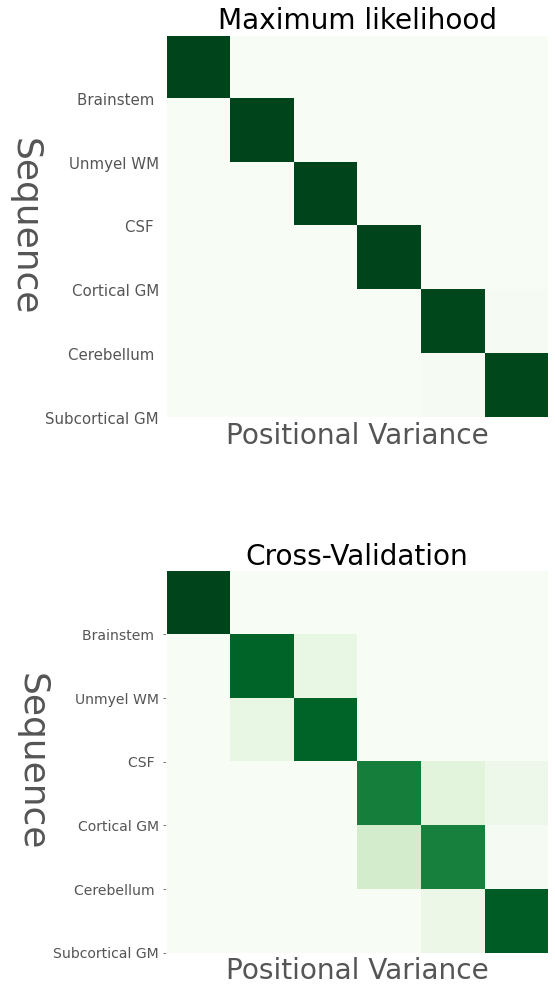

In [20]:
#*** Positional Variance Diagrams
pvd_cv, seq_cv = ebm_ute.extract_pvd(ml_order=seqs_cv,samples=mcmc_samples_cv)
#*** Positional Variance, reordered to match labels in events
reorder_cv = np.argsort(seq_cv)
pvd_cv_ = pvd_cv[:][reorder_cv]

############ It's no longer pretty from here, but it's easier to tweak the plots ############
ordr = 'cv_order'
seq_ = seq_cv
pvd_ = pvd_cv_
n_biomarkers = pvd_.shape[0]

fig, ax = plt.subplots(2,1,figsize=(10, 14),sharey=True)
labels = events_labels
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_]
ax[0].imshow(pvd_ml_[:][seq_], interpolation='nearest', cmap='Greens')
ax[0].set_title('Maximum likelihood',fontsize=28); txt1 = 'ML'
ax[1].imshow(pvd_cv_[:][seq_], interpolation='nearest', cmap='Greens')
ax[1].set_title('Cross-Validation',fontsize=28); txt2 = 'CV'
# ax[1].imshow(pvd_bs_fixedMM_[:][seq_], interpolation='nearest', cmap='Greens')
# ax[1].set_title('Sequence Bootstrap',fontsize=28); txt2 = 'PBS'
# ax[1].imshow(pvd_bs_[:][seq_], interpolation='nearest', cmap='Greens')
# ax[1].set_title('Full Bootstrap',fontsize=28); txt2 = 'FBS'

stp = 1
fs = 12
if n_biomarkers>8:
    stp = 3
    fs = 10
tick_marks_x = np.arange(0,n_biomarkers,stp)
tick_marks_x = []
x_labs = range(1, n_biomarkers+1,stp)
ax[0].set_xticks(tick_marks_x)
ax[1].set_xticks(tick_marks_x)
#ax[0].set_xticklabels(x_labs, rotation=0,fontsize=fs)
#ax[1].set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax[0].set_yticks(tick_marks_y+0.5)
ax[1].tick_params(left='off',labelleft='off')
ax[0].tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax[0].set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=15)
ax[0].set_ylabel('Sequence', fontsize=36,rotation=270,va='top')
ax[0].set_xlabel('Positional Variance', fontsize=28)
ax[1].set_ylabel('Sequence', fontsize=36,rotation=270,va='top')
ax[1].set_xlabel('Positional Variance', fontsize=28)
#ax[1].set_xlabel('Uncertainty', fontsize=32)
ax[0].grid(False)
ax[1].grid(False)
fig.tight_layout()
fig.subplots_adjust(hspace = 0.4)
f_name = '{0}-PVD_{1}vs{2}-{3}-{4}.png'.format(nom,txt1,txt2,rundate,ordr)
#fig.savefig(f_name,dpi=300)

In [21]:
############ Cross-Validation Similarity ############
#* CVS: 1 - Hellinger distance between folds, per event (row of positional variance diagram)
cvs, hd = ebm_ute.cv_similarity(mcmc_samples_cv,seq=seq_ml)
print('Cross-Validation similarity is {0}'.format(cvs))
hd_ = np.mean(hd,axis=0)

Cross-Validation similarity is 0.9065092394678005


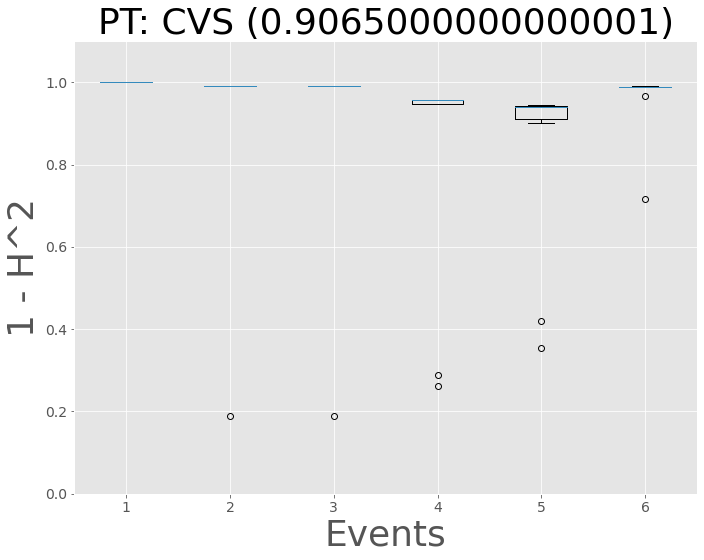

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(1-hd_**2)
ax.set_xlabel('Events',fontsize=36)
ax.set_ylabel('1 - H^2',fontsize=36)
ax.set_title('{0}: CVS ({1})'.format(nom_plus,np.around(cvs*100, 2)/100.0),fontsize=36)
ax.set_ylim([0,1.1])
fig.tight_layout()
f_name = '{0}-CVS-{1}.png'.format(nom,rundate)
#fig.savefig(f_name,dpi=300)

------

# Optional Part: Not included in main findings

----

## Model-based staging scores


In [23]:
cog_features = [
   'MDI 18-24 months', 'PDI 18-24 months', 'PMC 5 years','SES / Largo']
#cog_features = [
#    'MDI 18-24 months', 'PDI 18-24 months', 'PMC 5 years', 'Age gest', 'Birthweight (g)', 'SES / Largo'
#]

N = df_EBM['N'].values
for c in cog_features:
    print(c)
    df_EBM[c] = pd.to_numeric(df_EBM[c].values,errors='coerce')
    #fg = sn.FacetGrid(data=df_EBM, hue='DX', aspect=1.61)
    #fg.map(plt.scatter, 'N', c, ).add_legend()

MDI 18-24 months
PDI 18-24 months
PMC 5 years
SES / Largo


##  Staging using ML model stage

In [24]:
#*** Staging using ML model stage
df_staging = df_EBM.copy()
id_col = 'N'
#* If doing this with longitudinal data, add Visit numbers and years since BL
for id_k in df_staging[id_col].unique():
    rowz = (id_k==df_staging[id_col])
    indices = rowz.index[rowz].values
staging_columns = [id_col,'DX']+events+cog_features
df_staging = df_staging[staging_columns].copy()

x_long = df_staging[events].values
df_staging['Fraction missing data'] = np.sum(np.isnan(x_long),axis=1)/x_long.shape[1]
stage_column = "Model stage"

#* Maximum-likelihood model stage
prob_mat_ml, stages_long_ml, stage_likelihoods_long_ml = ebm_ute.ebm_3_staging(
    x=x_long,
    mixtures=kde_mixtures, # this is a list
    samples=mcmc_samples
)
df_staging[stage_column] = stages_long_ml

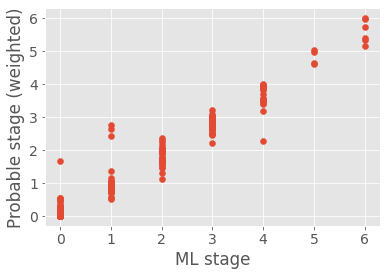

In [25]:
#*** Average stage, not ML
def stage_data(event_order, prob_mat):
    ### This is the default staging code
    p_yes = np.array(prob_mat[:, event_order, 1])
    p_no = np.array(prob_mat[:, event_order, 0])
    n_particp, n_biomarkers = p_yes.shape
    k = n_biomarkers+1
    stage_likelihoods = np.empty((n_particp, n_biomarkers+1))
    for i in range(k):
            stage_likelihoods[:, i] = np.prod(p_yes[:, :i], 1)*np.prod(p_no[:, i:n_biomarkers], 1)
    # Maximum-Likelihood stage
    stages = np.argmax(stage_likelihoods, axis=1)
    ### End of the default staging code
    
    #* Weighted-average stage: weighted by stage likelihood
    # instead of argmax, get the actual max probability across all events. 
    # this is the stage for patient j
    stage_likelihoods_max = np.tile(np.max(stage_likelihoods,axis=1).reshape(-1,1),(1,stage_likelihoods.shape[1]))
    # stage_likelihoods: the probabilities matrix [j,k]
    # stage_likelihoods_max: the max propagated to form a matrix [j,k]
    weights = stage_likelihoods / stage_likelihoods_max # this is a matrix division [j,k] / [j,k]
    #* compute the weighted average
    #print(np.tile(np.arange(0,n_biomarkers+1),(n_particp,1)))
    stages_weighted_avg = np.average(np.tile(np.arange(0,n_biomarkers+1),(n_particp,1)),
                                     axis=1,
                                     weights=stage_likelihoods)
    return stages, stage_likelihoods, stages_weighted_avg


stages_long_ml_2, stage_likelihoods_long_ml_2, stages_long_ml_avg = stage_data(event_order=seq_ml, prob_mat=prob_mat_ml)
df_staging[stage_column+'_avg'] = stages_long_ml_avg

#* ploting
fig,ax=plt.subplots()
ax.scatter(stages_long_ml,stages_long_ml_avg)
ax.set_xlabel('ML stage')
ax.set_ylabel('Probable stage (weighted)')
fig.show()

### Plots

ML MDI 18-24 months
6
ML PDI 18-24 months
6
ML PMC 5 years
6
ML SES / Largo
6


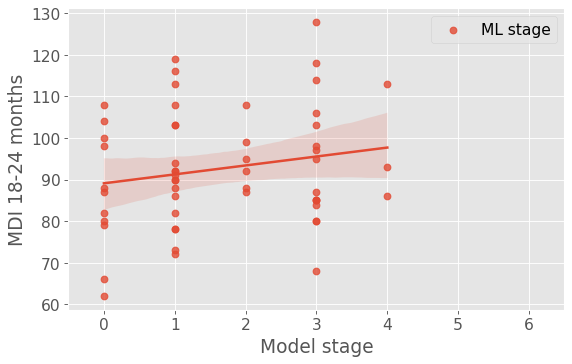

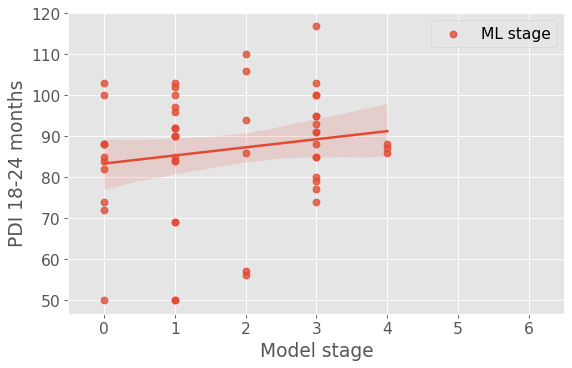

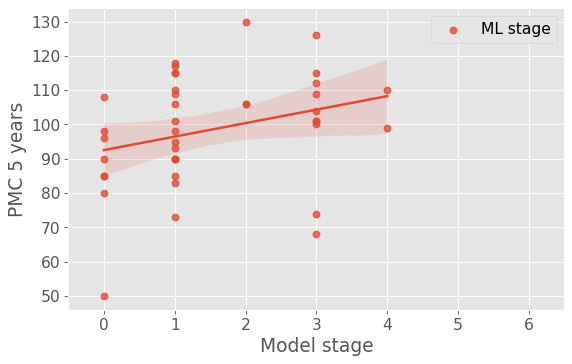

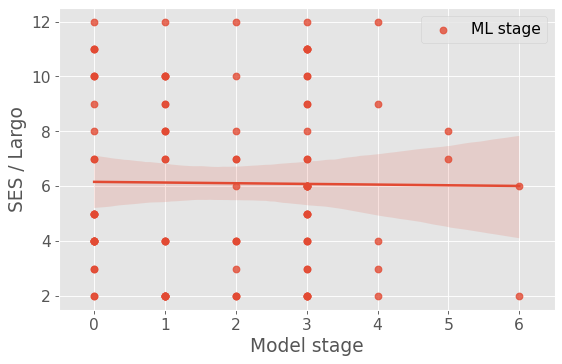

In [26]:
from sklearn.linear_model import RANSACRegressor

k=1
case = 'ML'

for c in cog_features:
    print(case,c)
    fig,ax=plt.subplots(figsize=(8,5), dpi=80)
    
    if case == 'avg':
        sn.regplot(x=stage_column + '_avg',y=c,data=df_staging[df_staging['DX']==1], ax=ax, label='average stage')
        ax.set_xlim([-0.5,len(events) + 0.5])
        #fig.savefig('./figs_2020/TEA_avg_{}_v2.png'.format(k))
    
    elif case=='ML':
        print(df_staging[df_staging['DX']==1][stage_column].max())
        sn.regplot(x=stage_column,y=c,data=df_staging[df_staging['DX']==1],ax=ax, label='ML stage')
        ax.set_xlim([-0.5,len(events) + 0.5])
        #fig.savefig('./figs_2020/TEA_ml_{}_v2.png'.format(k))
    
    plt.legend()
    k+=1

###  Random sample consensus regression

ML MDI 18-24 months
ML PDI 18-24 months
ML PMC 5 years
ML SES / Largo


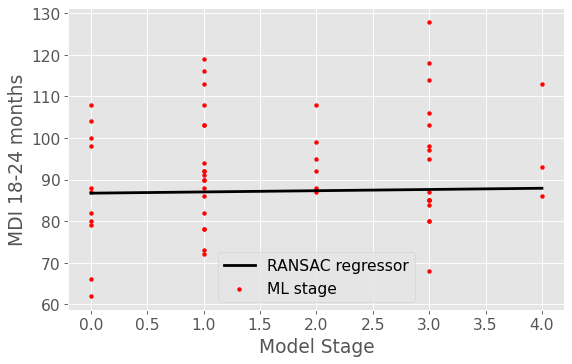

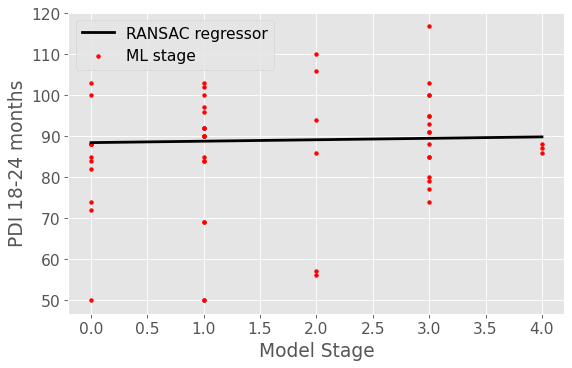

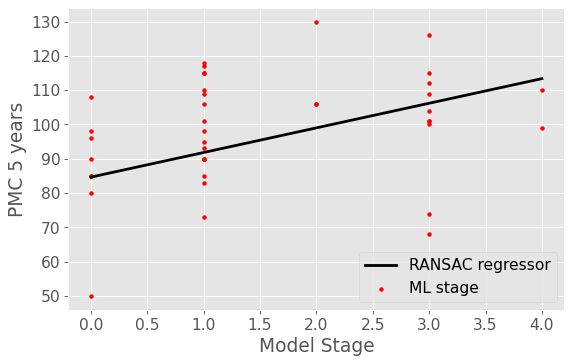

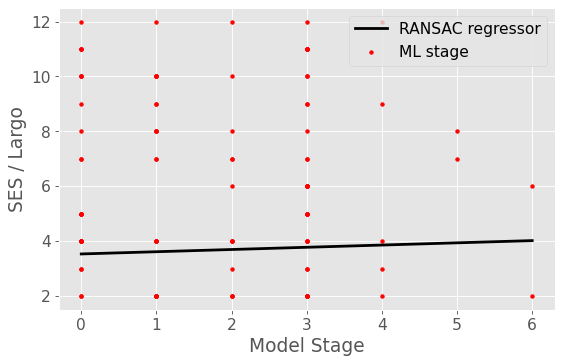

In [27]:
from sklearn.linear_model import RANSACRegressor
from scipy.stats import median_absolute_deviation

k=1
case = 'ML'

for c in cog_features:
    print(case,c)
    fig,ax=plt.subplots(figsize=(8,5), dpi=80)
    
    if case == 'avg':
        data=df_staging[df_staging['DX']==1] # only patients
        X, y  = data[stage_column + '_avg'].values.reshape(-1,1), data[c]
        mask = y.isna()
        X, y = X[~mask], y[~mask].values
        
        ransac = RANSACRegressor(random_state=10,min_samples=2,max_trials=1000).fit(X, y)
        
        line_X = np.arange(X.min(), X.max()+1)[:, np.newaxis]
        line_y_ransac = ransac.predict(line_X)
        
        ax.scatter(X,y, color='red', marker='.',s=45, label=case + ' ' + 'stage')
        ax.plot(line_X, line_y_ransac, color='k', linewidth=2.5, label='RANSAC regressor')
        ax.set_xlabel("Model Stage"); ax.set_ylabel(c)
        #fig.savefig('./figs_2020/robust_TEA_avg_{}_v2.png'.format(k))
    
    elif case=='ML':
        data=df_staging[df_staging['DX']==1]
        X, y  = data[stage_column].values.reshape(-1,1), data[c]
        mask = y.isna()
        X, y = X[~mask], y[~mask].values
            
        ransac = RANSACRegressor(random_state=10,min_samples=2,max_trials=1000).fit(X, y)
        
        line_X = np.arange(X.min(), X.max()+1)[:, np.newaxis]
        line_y_ransac = ransac.predict(line_X)
        ax.scatter(X,y, color='red', marker='.', s=45, label=case + ' ' + 'stage')
        ax.plot(line_X, line_y_ransac, color='k', linewidth=2.5, label='RANSAC regressor')
        ax.set_xlabel("Model Stage"); ax.set_ylabel(c)
        #fig.savefig('./figs_2020/robust_TEA_ml_{}_v2.png'.format(k))
    
    plt.legend()
    k+=1

### Estimate  Pearson's $\rho$ 

In [28]:
stage_column

'Model stage'

In [29]:
k=1
for c in cog_features:
    print(c)
    nan_index = pd.isna(df_staging[df_staging['DX']==1][c]).values
    stag = df_staging[df_staging['DX']==1].loc[~nan_index, stage_column].values
    cogn = df_staging[df_staging['DX']==1].loc[~nan_index, c].values
    print("ML: Rho is {}".format(np.corrcoef(cogn, stag)[0][1]))
    
    stag = df_staging[df_staging['DX']==1].loc[~nan_index, stage_column+'_avg'].values
    cogn = df_staging[df_staging['DX']==1].loc[~nan_index, c].values
    print("Avg: Rho is {}\n".format(np.corrcoef(cogn, stag)[0][1]))
    k+=1

MDI 18-24 months
ML: Rho is 0.18960774798527644
Avg: Rho is 0.24394139175663526

PDI 18-24 months
ML: Rho is 0.1698739036231588
Avg: Rho is 0.2026209050634997

PMC 5 years
ML: Rho is 0.29550630025653396
Avg: Rho is 0.3615778986277222

SES / Largo
ML: Rho is -0.011521390188374338
Avg: Rho is -0.05816645228213551



##  Staging using CV model stage

In [30]:
#* Maximum-likelihood model stage
prob_mat_cv, stages_long_cv, stage_likelihoods_long_cv = ebm_ute.ebm_3_staging(
    x=x_long,
    mixtures=kde_mixtures_cv, # the CV mixtures
    samples=mcmc_samples_cv  # the CV mcmc samples
)

#* CV sequence and staging: average event probabilities over folds
prob_mat_cv_merged = np.mean( np.array([p for p in prob_mat_cv]) , axis=0 )
#*
stages_long_cv_merged, stage_likelihoods_long_cv_merged, stages_long_cv_merged_avg = stage_data(event_order=seq_cv, prob_mat=prob_mat_cv_merged)

#*** Choose CV
prob_mat = np.array([p for p in prob_mat_cv])
stages_long = np.array([s for s in stages_long_cv])
stage_likelihoods_long = np.array([sl for sl in stage_likelihoods_long_cv])

# Average over folds
prob_mat = np.mean(prob_mat,axis=0)
stages_long = np.round(np.mean(stages_long,axis=0)).astype(int)
stage_likelihoods_long = np.mean(stage_likelihoods_long,axis=0)
prob_mat_mean = np.mean(prob_mat,axis=0)
nom_staging = 'rcv'
nom_stag = 'weighted_avg-stage'

# put the rounded average CV stage vector into the dataframe
df_staging[stage_column + '_cv'] = stages_long

MDI 18-24 months
PDI 18-24 months
PMC 5 years
SES / Largo


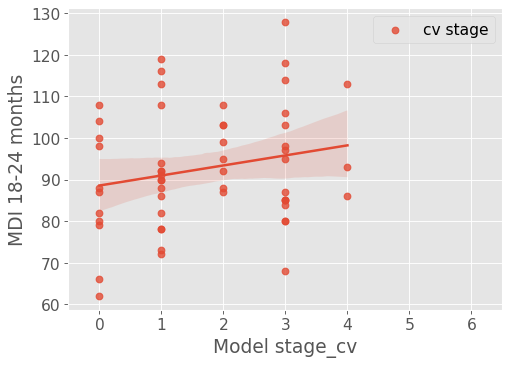

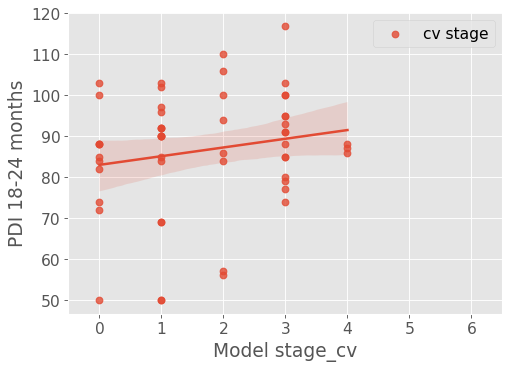

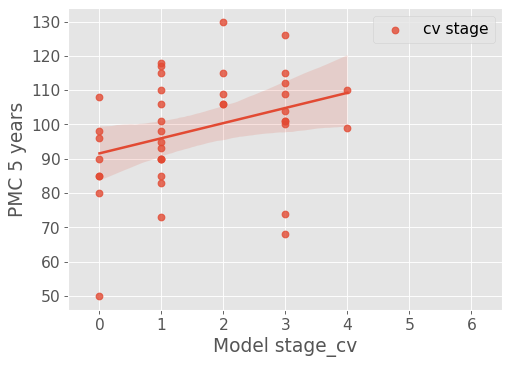

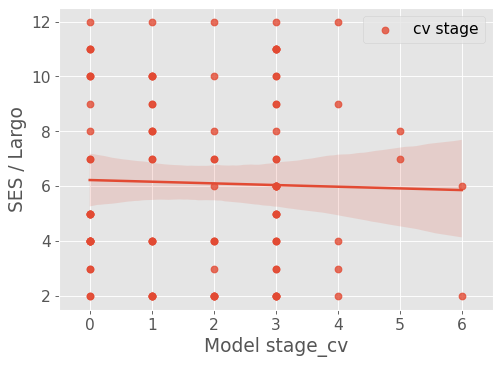

In [31]:
k=1
for c in cog_features:
    print(c)
    fig,ax=plt.subplots(figsize=(7,5), dpi=80)
    
    sn.regplot(x=stage_column+'_cv',y=c,data=df_staging[df_staging['DX']==1], ax=ax, label='cv stage')
    ax.set_xlim([-0.5,len(events) + 0.5])
    #fig.savefig('./figs_2020/TEA_cv_{}_v2.png'.format(k))
    
    plt.legend()
    k+=1

In [32]:
k=1
for c in cog_features:
    print(c)
    nan_index = pd.isna(df_staging[df_staging['DX']==1][c]).values
    stag = df_staging[df_staging['DX']==1].loc[~nan_index, stage_column+'_cv'].values
    cogn = df_staging[df_staging['DX']==1].loc[~nan_index, c].values
    print("Rho is {}\n".format(np.corrcoef(cogn, stag)[0][1]))
    k+=1

MDI 18-24 months
Rho is 0.2121000650902045

PDI 18-24 months
Rho is 0.1816378125183263

PMC 5 years
Rho is 0.3310109416599206

SES / Largo
Rho is -0.028190445472106692



### Robust regression

MDI 18-24 months
PDI 18-24 months
PMC 5 years
SES / Largo


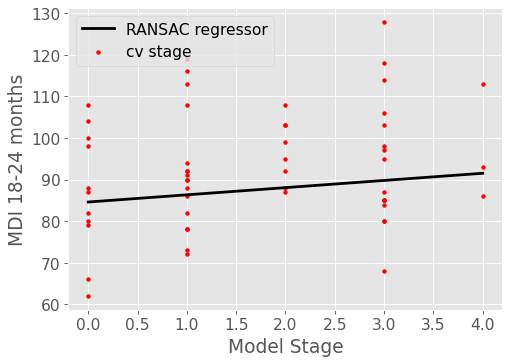

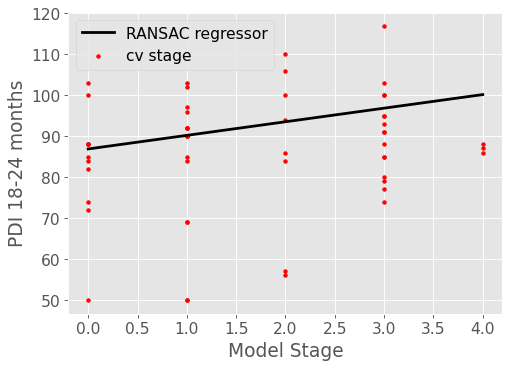

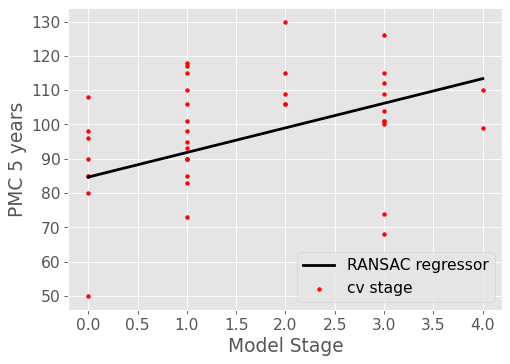

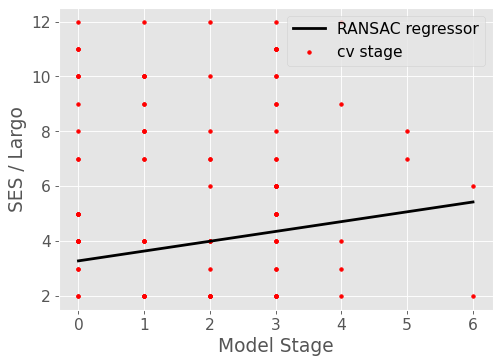

In [33]:
k=1
for c in cog_features:
    print(c)
    fig,ax=plt.subplots(figsize=(7,5), dpi=80)
    
    data=df_staging[df_staging['DX']==1]
    X, y  = data[stage_column+'_cv'].values.reshape(-1,1), data[c]
    mask = y.isna()
    X, y = X[~mask], y[~mask].values

    ransac = RANSACRegressor(random_state=0,min_samples= 3 ,max_trials=1000).fit(X, y)
    
    line_X = np.arange(X.min(), X.max()+1.0)[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    ax.scatter(X,y, color='red', marker='.', s=45, label= 'cv stage')
    ax.plot(line_X, line_y_ransac, color='k', linewidth=2.5, label='RANSAC regressor')   
    ax.set_xlabel("Model Stage"); ax.set_ylabel(c)
    ax.legend()
    #fig.savefig('./figs_2020/robust_TEA_cv_{}_v2.png'.format(k))
    
    k+=1

----